In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns
from umap import UMAP
import os

In [2]:
# this cell runs this pipeline and saves the data for all chr.
# for individual analysis, see each cells below 
# note = individual cell may not be updated (refer back to this cell for updated code)

# spline and temporal feature extraction
def extract_temporal_features(data, times=[12, 18, 24], attr='expr'):
    # Spline fit
    spline = UnivariateSpline(times, data, s=0, k=2)  # k=2: quadratic, s=0: interpolates
    ts = np.linspace(12, 24, 100)
    curve = spline(ts)
    
    # Peak time
    peak_idx = np.argmax(curve)
    peak_time = ts[peak_idx]
    
    # Amplitude
    amplitude = np.max(curve) - np.min(curve)
    
    # Inflection points (where the first derivative changes sign)
    deriv = spline.derivative()(ts)
    inflection_points = np.where(np.diff(np.sign(deriv)))[0]
    num_inflections = len(inflection_points)
    
    # Rise and fall durations
    # Rise: time from min to max; Fall: time from max to min
    min_idx = np.argmin(curve)
    max_idx = peak_idx
    rise_duration = ts[max_idx] - ts[min_idx] if max_idx > min_idx else 0
    fall_duration = ts[min_idx] - ts[max_idx] if max_idx < min_idx else 0
    
    return {
        f'{attr}_peak_time': peak_time,
        f'{attr}_amplitude': amplitude,
        f'{attr}_num_inflections': num_inflections,
        f'{attr}_rise_duration': rise_duration,
        f'{attr}_fall_duration': fall_duration
    }

def extract_temporal_curve_features(file_path):
    for chr_folder_name in os.listdir(file_path):
        chr_path = os.path.join(file_path, chr_folder_name)
        if not os.path.isdir(chr_path) or not chr_folder_name.startswith('chr'):
            continue
        df = pd.read_csv(f"{file_path}{chr_folder_name}/{chr_folder_name}_temporal_trendCategories_valuePattern.csv")

        # extract expression trajectories
        expr_cols = ['expr_delta_12h', 'expr_delta_18h', 'expr_delta_24h']
        df_expr = df.dropna(subset=expr_cols).copy()
        print(f"Total genes with expression data: {len(df_expr)}")

        # Compute temporal features for expression
        features = []
        for _, row in df_expr.iterrows():
            series = row[expr_cols].values
            feats = extract_temporal_features(series, attr="expr")
            feats["gene_name"] = row["gene_name"]
            features.append(feats)

        features_df = pd.DataFrame(features)
        merged_df = pd.merge(df_expr, features_df, on="gene_name", how="left")


        # Save with new features
        output_file = os.path.join(chr_path, f"{chr_folder_name}_temporal_trendCategories_valuePattern_curveFeatures.csv")
        merged_df.to_csv(output_file, index=False)

        print(f"{chr_folder_name} data saved")

file_path = 'data/green_monkey/all_structure_files/'
extract_temporal_curve_features(file_path)

Total genes with expression data: 397
chr23 data saved
Total genes with expression data: 589
chr12 data saved
Total genes with expression data: 309
chr15 data saved
Total genes with expression data: 480
chr14 data saved
Total genes with expression data: 251
chr13 data saved
Total genes with expression data: 409
chr25 data saved
Total genes with expression data: 507
chr22 data saved
Total genes with expression data: 225
chr4 data saved
Total genes with expression data: 237
chr3 data saved
Total genes with expression data: 482
chr2 data saved
Total genes with expression data: 614
chr5 data saved
Total genes with expression data: 201
chr18 data saved
Total genes with expression data: 177
chr27 data saved
Total genes with expression data: 1141
chr20 data saved
Total genes with expression data: 155
chr29 data saved
Total genes with expression data: 960
chr16 data saved
Total genes with expression data: 479
chr10 data saved
Total genes with expression data: 218
chr28 data saved
Total genes w

In [3]:
# load data
df = pd.read_csv("data/green_monkey/all_structure_files/chr1/chr1_expr_acc_features.csv")
df.head()


,gene_name,expr_delta_12h,expr_delta_18h,expr_delta_24h,acc_delta_12h_tss,acc_delta_18h_tss,acc_delta_24h_tss
0,SCGB1C1,NaN,NaN,NaN,6.35975,2.42210,NaN
1,ODF3,NaN,NaN,NaN,-0.38124,1.51588,-0.92500
2,BET1L,-0.315039,-0.368512,-0.155558,-12.69878,2.12003,8.26010
3,RIC8A,-0.295795,-0.221668,-0.362167,-14.72109,1.21380,-22.87729
4,SIRT3,0.552196,-0.984313,0.300940,0.86934,-0.35920,-1.09724


In [4]:
# extract expression trajectories
expr_cols = ['expr_delta_12h', 'expr_delta_18h', 'expr_delta_24h']
df_expr = df.dropna(subset=expr_cols).copy()
print(f"Total genes with expression data: {len(df_expr)}")


Total genes with expression data: 1003


In [5]:
# spline and temporal feature extraction
def extract_temporal_features(expr, times=[12, 18, 24]):
    # Spline fit
    spline = UnivariateSpline(times, expr, s=0, k=2)  # k=2: quadratic, s=0: interpolates
    ts = np.linspace(12, 24, 100)
    curve = spline(ts)
    
    # Peak time
    peak_idx = np.argmax(curve)
    peak_time = ts[peak_idx]
    
    # Amplitude
    amplitude = np.max(curve) - np.min(curve)
    
    # Inflection points (where the first derivative changes sign)
    deriv = spline.derivative()(ts)
    inflection_points = np.where(np.diff(np.sign(deriv)))[0]
    num_inflections = len(inflection_points)
    
    # Rise and fall durations
    # Rise: time from min to max; Fall: time from max to min
    min_idx = np.argmin(curve)
    max_idx = peak_idx
    rise_duration = ts[max_idx] - ts[min_idx] if max_idx > min_idx else 0
    fall_duration = ts[min_idx] - ts[max_idx] if max_idx < min_idx else 0
    
    return {
        'peak_time': peak_time,
        'amplitude': amplitude,
        'num_inflections': num_inflections,
        'rise_duration': rise_duration,
        'fall_duration': fall_duration
    }


In [6]:
# feature computation
features = []
for i, row in df_expr.iterrows():
    expr = row[expr_cols].values.astype(float)
    feats = extract_temporal_features(expr)
    feats['gene_name'] = row['gene_name']
    features.append(feats)

feat_df = pd.DataFrame(features)
feat_df.set_index('gene_name', inplace=True)
feat_df.head()


,peak_time,amplitude,num_inflections,rise_duration,fall_duration
gene_name,,,,,
BET1L,24.000000,0.224881,1,7.757576,0.000000
RIC8A,17.090909,0.143064,1,0.000000,6.909091
SIRT3,12.000000,1.539255,1,0.000000,6.303030
PSMD13,24.000000,0.133979,1,7.030303,0.000000
NLRP6,24.000000,3.830052,1,8.969697,0.000000


In [7]:
# normalization and clustering
X = feat_df.values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Cluster (try 4 clusters as an example)
kmeans = KMeans(n_clusters=4, random_state=0)
labels = kmeans.fit_predict(X_scaled)
feat_df['cluster'] = labels


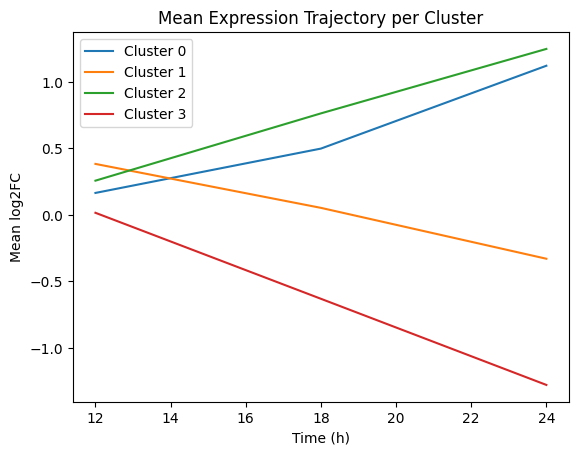

In [8]:
# avg trajectory per cluster
df_expr['cluster'] = feat_df['cluster'].reindex(df_expr['gene_name']).values

for c in sorted(df_expr['cluster'].unique()):
    genes = df_expr[df_expr['cluster'] == c]
    mean_traj = genes[expr_cols].mean().values
    plt.plot([12, 18, 24], mean_traj, label=f'Cluster {c}')
plt.xlabel('Time (h)')
plt.ylabel('Mean log2FC')
plt.legend()
plt.title('Mean Expression Trajectory per Cluster')
plt.show()


/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


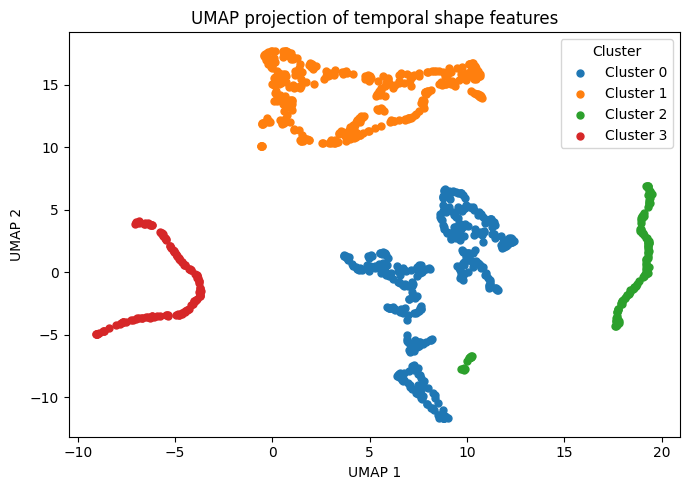

In [9]:
umap_proj = UMAP(n_neighbors=10, min_dist=0.3, random_state=42).fit_transform(X_scaled)

plt.figure(figsize=(7,5))
for c in np.unique(labels):
    idx = labels == c
    plt.scatter(umap_proj[idx, 0], umap_proj[idx, 1], 
                label=f'Cluster {c}', s=25)
plt.title('UMAP projection of temporal shape features')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()